# Federated Machine Learning

This demo illustrates a simple Federated Learning algorithm. We use it to train the Fashion-MNIST dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# disable tensorflow warnings

import logging
logging.getLogger('tensorflow').disabled = True
import tensorflow as tf

In [3]:
import keras
from util import *
from server import FederatedServer

## Load the Fashion MNIST dataset

In [4]:
# Load the Fashion mnist dataset

dataset = keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = dataset.load_data()    

## Create a simple 3 layer NN

In [7]:
import keras

# For demo purposes, use a simple model that will do a decent enough job
def build_simple_model():
    """
    A simple model for classifying 28x28 images
    :return: the model
    """
    return keras.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Rescaling(scale=1 / 255),
        keras.layers.Dense(300, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])


def build_and_compile_simple_model():
    """
    A simple model for classifying 28x28 images, compiled for training
    :return: the compiled model
    """
    model = build_simple_model()
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer='adam',
                  metrics=[keras.metrics.sparse_categorical_accuracy])
    return model


## Train directly without Federated Learning

In [6]:
# First train in a non-Federated manner, using the entity data set
model = build_and_compile_simple_model()
model.fit(X_train, y_train, epochs=10)
loss, accuracy = model.evaluate(X_test, y_test)
print(f" accuracy: {accuracy} | loss: {loss}")

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4803 - sparse_categorical_accuracy: 0.8280
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.8676
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3253 - sparse_categorical_accuracy: 0.8792
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.8871
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2857 - sparse_categorical_accuracy: 0.8939
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9007
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2548 - sparse_categorical_accuracy: 0.9028
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2439 - sparse_categorical_accuracy: 0.9076
Epoch 9/10
1875/1875 [==========

## Federated ML

In [8]:
# shuffle the training data
shuffle_together(X_train, y_train)

# split the training data between the server and the clients
shard_ratios = [0.2, 0.3, 0.1, 0.2, 0.2]
shards = split_data(X_train, y_train, shard_ratios)
# assign the first shard to the server for pre-training
X_server, y_server = shards[0]

# create the clients
clients = create_clients(shards=shards[1:], create_model_fn=build_and_compile_simple_model)

In [9]:
# Create a model for the server for testing
server_model = build_and_compile_simple_model()
# Create the central server and run federated learning for 10 iterations
server = FederatedServer(server_model, clients, batch_size=10, client_epochs=1)
tracker = HistoryTracker(X_server, y_server)
server.train(iterations=10, evaluate_fn=tracker)

Server iteration 0
Fitting local model for client client_1
Fitting local model for client client_2
Fitting local model for client client_3
Fitting local model for client client_4
375/375 [==============================] - 1s 1ms/step - loss: 0.5449 - sparse_categorical_accuracy: 0.8156
Server iteration 1
Fitting local model for client client_1
Fitting local model for client client_2
Fitting local model for client client_3
Fitting local model for client client_4
375/375 [==============================] - 1s 1ms/step - loss: 0.3945 - sparse_categorical_accuracy: 0.8604
Server iteration 2
Fitting local model for client client_1
Fitting local model for client client_2
Fitting local model for client client_3
Fitting local model for client client_4
375/375 [==============================] - 1s 1ms/step - loss: 0.3777 - sparse_categorical_accuracy: 0.8609
Server iteration 3
Fitting local model for client client_1
Fitting local model for client client_2
Fitting local model for client client_3


In [10]:
# Evaluate the final model on the validation set

loss, accuracy = server_model.evaluate(X_test, y_test)
print(f" accuracy: {accuracy} | loss: {loss}")

313/313 [==============================] - 0s 1ms/step - loss: 0.3529 - sparse_categorical_accuracy: 0.8748
 accuracy: 0.8748000264167786 | loss: 0.3528728783130646


## Plot training history

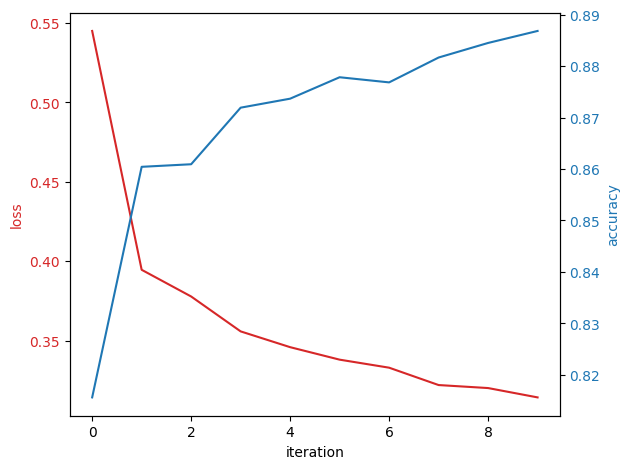

In [12]:
import matplotlib.pyplot as plt

loss_history, accuracy_history = tracker.get_history()
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss', color=color)
ax1.plot(loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracy_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.savefig("training_history.png")
plt.show()